# Hurricane Damage Detector

## Get and Load Dataset

In [179]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [180]:
!gdown --id 1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK
From (redirected): https://drive.google.com/uc?id=1pByxsenTnJGBKnKhLTXBqbUN_Kbm7PNK&confirm=t&uuid=6bfed721-7eff-4ecc-9137-32f71c847710
To: /content/hurricane_detector.zip
100% 39.7M/39.7M [00:00<00:00, 132MB/s]


In [181]:
#!unzip -q hurricane_detector.zip

In [182]:
ls -l

total 38752
-rw-r--r-- 1 root root 39662128 Jun 23 11:42 hurricane_detector.zip
drwxr-xr-x 1 root root     4096 Jun 21 21:47 sample_data/
drwxr-xr-x 4 root root     4096 Jun 23 08:53 test_hurricane/
drwxr-xr-x 4 root root     4096 Jun 23 08:53 train_hurricane/


In [183]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [184]:
!tree --dirsfirst --filelimit 2 ./train_hurricane/

./train_hurricane/
├── damage [655 entries exceeds filelimit, not opening dir]
└── no_damage [703 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [185]:
!tree --dirsfirst --filelimit 2 ./test_hurricane/

./test_hurricane/
├── damage [5895 entries exceeds filelimit, not opening dir]
└── no_damage [6333 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Load Dependencies

In [186]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.12.0


## Utility functions to create dataset generators

In [187]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_hurricane",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


# **Image Augmentation**

In [188]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=classes,
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = image_dataset_from_directory(
        "./train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=classes,
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.map(
        lambda image, label: (tf.image.random_flip_left_right(image), label)
    ).map(
        lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label)
    ).shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = image_dataset_from_directory(
        "./test_hurricane",
        class_names=classes,
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions


In [189]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Prepare train and validation datasets
train_ds, val_ds = prepare_train_and_val_datasets()

# Create the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)  # Dropout layer with dropout rate of 0.5
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x)  # Dropout layer with dropout rate of 0.5
#x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])




Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


In [190]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [191]:
# Train the model
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

# Evaluate the model on the test data
y_true, y_pred = eval_model_on_test(model)


Epoch 1/10
34/34 [==============================] - 15s 146ms/step - loss: 0.3960 - accuracy: 0.8390 - val_loss: 0.2351 - val_accuracy: 0.9151
Epoch 2/10
34/34 [==============================] - 4s 82ms/step - loss: 0.1828 - accuracy: 0.9246 - val_loss: 0.2302 - val_accuracy: 0.9151
Epoch 3/10
34/34 [==============================] - 3s 56ms/step - loss: 0.1517 - accuracy: 0.9494 - val_loss: 0.2286 - val_accuracy: 0.9225
Epoch 4/10
34/34 [==============================] - 2s 49ms/step - loss: 0.1082 - accuracy: 0.9577 - val_loss: 0.2540 - val_accuracy: 0.9188
Epoch 5/10
34/34 [==============================] - 3s 58ms/step - loss: 0.0753 - accuracy: 0.9761 - val_loss: 0.3126 - val_accuracy: 0.9151
Epoch 6/10
34/34 [==============================] - 3s 48ms/step - loss: 0.1076 - accuracy: 0.9568 - val_loss: 0.3195 - val_accuracy: 0.9041
Epoch 7/10
34/34 [==============================] - 2s 49ms/step - loss: 0.0960 - accuracy: 0.9586 - val_loss: 0.1943 - val_accuracy: 0.9262
Epoch 8/10


Predicting on Test Data:   0%|          | 0/96 [00:00<?, ?it/s]

4/4 [==============================] - 1s 46ms/step


Predicting on Test Data:   1%|          | 1/96 [00:01<02:46,  1.76s/it]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:   2%|▏         | 2/96 [00:02<01:23,  1.13it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:   3%|▎         | 3/96 [00:02<00:56,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   4%|▍         | 4/96 [00:02<00:43,  2.13it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:   5%|▌         | 5/96 [00:02<00:36,  2.46it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:   6%|▋         | 6/96 [00:03<00:32,  2.78it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   7%|▋         | 7/96 [00:03<00:28,  3.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   8%|▊         | 8/96 [00:03<00:26,  3.31it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:   9%|▉         | 9/96 [00:03<00:25,  3.47it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  10%|█         | 10/96 [00:04<00:23,  3.60it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  11%|█▏        | 11/96 [00:04<00:22,  3.70it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  12%|█▎        | 12/96 [00:04<00:22,  3.74it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  14%|█▎        | 13/96 [00:04<00:22,  3.74it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  15%|█▍        | 14/96 [00:05<00:21,  3.81it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  16%|█▌        | 15/96 [00:05<00:21,  3.83it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  17%|█▋        | 16/96 [00:05<00:20,  3.90it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  18%|█▊        | 17/96 [00:05<00:20,  3.90it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  19%|█▉        | 18/96 [00:06<00:19,  3.92it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  20%|█▉        | 19/96 [00:06<00:19,  3.98it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  21%|██        | 20/96 [00:06<00:19,  3.97it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  22%|██▏       | 21/96 [00:06<00:19,  3.88it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  23%|██▎       | 22/96 [00:07<00:18,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  24%|██▍       | 23/96 [00:07<00:18,  3.87it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  25%|██▌       | 24/96 [00:07<00:18,  3.92it/s]

4/4 [==============================] - 0s 29ms/step


Predicting on Test Data:  26%|██▌       | 25/96 [00:07<00:18,  3.85it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  27%|██▋       | 26/96 [00:08<00:17,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  28%|██▊       | 27/96 [00:08<00:17,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  29%|██▉       | 28/96 [00:08<00:17,  3.84it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  30%|███       | 29/96 [00:09<00:18,  3.70it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  31%|███▏      | 30/96 [00:09<00:18,  3.48it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  32%|███▏      | 31/96 [00:09<00:19,  3.38it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  33%|███▎      | 32/96 [00:10<00:19,  3.26it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  34%|███▍      | 33/96 [00:10<00:19,  3.20it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  35%|███▌      | 34/96 [00:10<00:19,  3.18it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  36%|███▋      | 35/96 [00:11<00:19,  3.13it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  38%|███▊      | 36/96 [00:11<00:19,  3.09it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  39%|███▊      | 37/96 [00:11<00:18,  3.19it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  40%|███▉      | 38/96 [00:11<00:17,  3.38it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  41%|████      | 39/96 [00:12<00:16,  3.50it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  42%|████▏     | 40/96 [00:12<00:15,  3.64it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  43%|████▎     | 41/96 [00:12<00:14,  3.71it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  44%|████▍     | 42/96 [00:12<00:14,  3.80it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  45%|████▍     | 43/96 [00:13<00:13,  3.82it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  46%|████▌     | 44/96 [00:13<00:13,  3.85it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  47%|████▋     | 45/96 [00:13<00:13,  3.77it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  48%|████▊     | 46/96 [00:13<00:13,  3.79it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  49%|████▉     | 47/96 [00:14<00:12,  3.82it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  50%|█████     | 48/96 [00:14<00:12,  3.86it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  51%|█████     | 49/96 [00:14<00:12,  3.86it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  52%|█████▏    | 50/96 [00:14<00:11,  3.90it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  53%|█████▎    | 51/96 [00:15<00:11,  3.87it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  54%|█████▍    | 52/96 [00:15<00:11,  3.84it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  55%|█████▌    | 53/96 [00:15<00:11,  3.85it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  56%|█████▋    | 54/96 [00:16<00:10,  3.85it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  57%|█████▋    | 55/96 [00:16<00:10,  3.84it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  58%|█████▊    | 56/96 [00:16<00:10,  3.88it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  59%|█████▉    | 57/96 [00:16<00:10,  3.90it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  60%|██████    | 58/96 [00:17<00:09,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  61%|██████▏   | 59/96 [00:17<00:09,  3.94it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  62%|██████▎   | 60/96 [00:17<00:09,  3.96it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  64%|██████▎   | 61/96 [00:17<00:08,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  65%|██████▍   | 62/96 [00:18<00:08,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  66%|██████▌   | 63/96 [00:18<00:08,  3.93it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  67%|██████▋   | 64/96 [00:18<00:08,  3.95it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  68%|██████▊   | 65/96 [00:18<00:07,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  69%|██████▉   | 66/96 [00:19<00:07,  3.90it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  70%|██████▉   | 67/96 [00:19<00:07,  3.87it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  71%|███████   | 68/96 [00:19<00:07,  3.92it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  72%|███████▏  | 69/96 [00:19<00:06,  3.87it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  73%|███████▎  | 70/96 [00:20<00:06,  3.90it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  74%|███████▍  | 71/96 [00:20<00:06,  3.88it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  75%|███████▌  | 72/96 [00:20<00:06,  3.91it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  76%|███████▌  | 73/96 [00:20<00:05,  3.90it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  77%|███████▋  | 74/96 [00:21<00:05,  3.89it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  78%|███████▊  | 75/96 [00:21<00:05,  3.84it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  79%|███████▉  | 76/96 [00:21<00:05,  3.54it/s]

4/4 [==============================] - 0s 32ms/step


Predicting on Test Data:  80%|████████  | 77/96 [00:22<00:05,  3.32it/s]

4/4 [==============================] - 0s 34ms/step


Predicting on Test Data:  81%|████████▏ | 78/96 [00:22<00:05,  3.24it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  82%|████████▏ | 79/96 [00:22<00:05,  3.15it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  83%|████████▎ | 80/96 [00:23<00:05,  3.13it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  84%|████████▍ | 81/96 [00:23<00:04,  3.10it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  85%|████████▌ | 82/96 [00:23<00:04,  3.11it/s]

4/4 [==============================] - 0s 33ms/step


Predicting on Test Data:  86%|████████▋ | 83/96 [00:24<00:04,  3.19it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  88%|████████▊ | 84/96 [00:24<00:03,  3.36it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  89%|████████▊ | 85/96 [00:24<00:03,  3.52it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  90%|████████▉ | 86/96 [00:24<00:02,  3.60it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  91%|█████████ | 87/96 [00:25<00:02,  3.81it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  92%|█████████▏| 88/96 [00:25<00:02,  3.87it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  93%|█████████▎| 89/96 [00:25<00:01,  3.94it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  94%|█████████▍| 90/96 [00:25<00:01,  4.01it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  95%|█████████▍| 91/96 [00:25<00:01,  4.12it/s]

4/4 [==============================] - 0s 30ms/step


Predicting on Test Data:  96%|█████████▌| 92/96 [00:26<00:00,  4.23it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  97%|█████████▋| 93/96 [00:26<00:00,  4.18it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  98%|█████████▊| 94/96 [00:26<00:00,  4.20it/s]

4/4 [==============================] - 0s 31ms/step


Predicting on Test Data:  99%|█████████▉| 95/96 [00:26<00:00,  4.22it/s]

3/3 [==============================] - 1s 29ms/step


Predicting on Test Data: 100%|██████████| 96/96 [00:28<00:00,  3.39it/s]


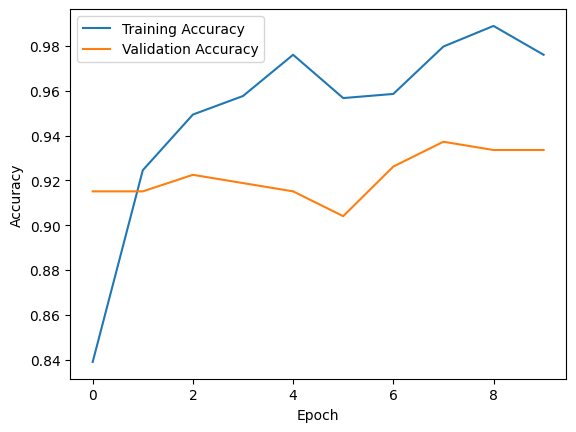

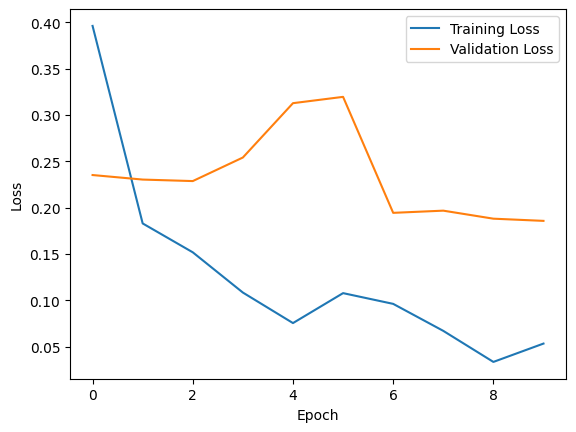

In [197]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [193]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(val_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

9/9 [==============================] - 0s 40ms/step - loss: 0.1856 - accuracy: 0.9336
Test Loss: 0.1856057494878769
Test Accuracy: 0.9335793256759644


In [194]:
import numpy as np
import sklearn.metrics as metrics

# Convert predicted probabilities to binary predictions
y_pred_binary = np.round(y_pred).astype(int)

# Generate confusion matrix
confusion = metrics.confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(confusion)

# Generate classification report
classification_report = metrics.classification_report(y_true, y_pred_binary)
print("Classification Report:")
print(classification_report)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_true, y_pred_binary)
print("Accuracy:", accuracy)


Confusion Matrix:
[[5978  355]
 [ 396 5499]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6333
           1       0.94      0.93      0.94      5895

    accuracy                           0.94     12228
   macro avg       0.94      0.94      0.94     12228
weighted avg       0.94      0.94      0.94     12228

Accuracy: 0.9385835786719006


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [195]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.
Using 1087 files for training.
Found 1358 files belonging to 2 classes.
Using 271 files for validation.


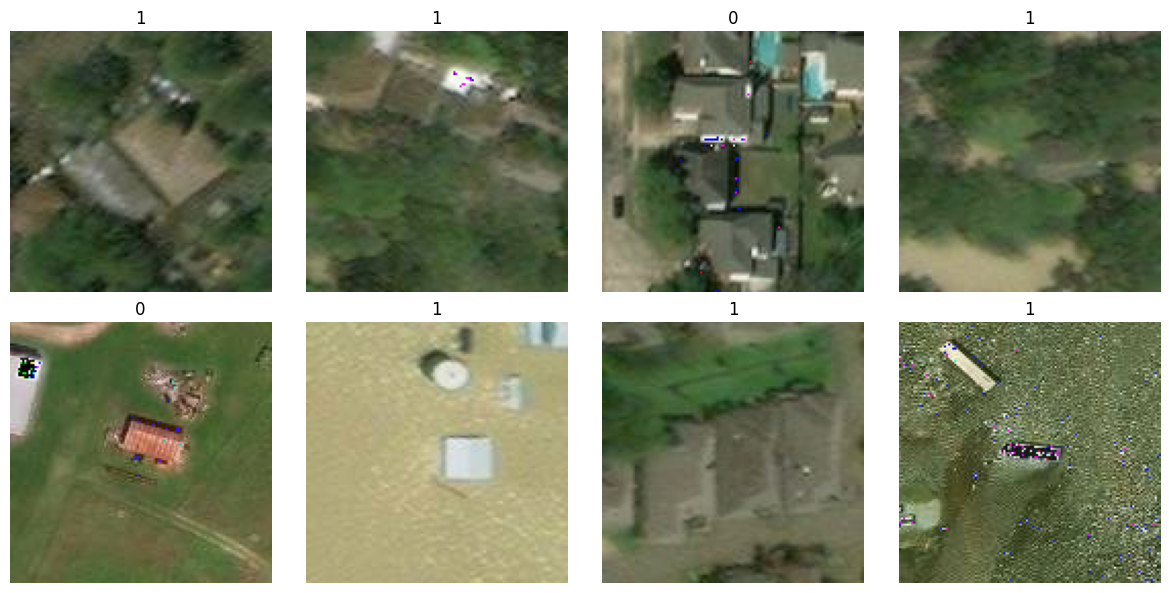

In [196]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## If you want to apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:

```
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))
```


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__